# KSA: Polar Observations and Modelling

# Week 6 - Satellite observations

## How is dynamic topography related to surface currents?

If you place a tennis ball on a level surface it won't move, but if that surface was tilted, gravity will induce (a downward) motion. Something similar happens in large scales in the ocean. The tilting of the ocean surface with respect to the geoid (our reference surface of equal gravity) will induce motion of water masses through the establishment of a pressure gradient; and this motion is in turn affected by the Earth's rotation due to the large scale involved. The resulting balance between the pressure gradient force ($\frac{\partial P}{\partial x}$, $\frac{\partial P}{\partial y}$) and the Earth's rotation (the Coriolis force, $f$) is called **geostrophic balance**. The geostrophic balance can be written as:

<div style="float: right; margin-right: 20px; margin-left: 30px; width: 40%; max-width: 500px;">
    <img src="images/geostrophy.png" width="100%"/>
</div>

$$
f \ u = -\frac{1}{\rho} \frac{\partial P}{\partial y} \; \quad \quad \; f \ v  = \frac{1}{\rho} \frac{\partial P}{\partial x}
$$


Using the geostrophic balance, we can calculate **geostrophic velocities** ($u$, $v$), which at the surface are a good approximation of the actual surface velocities (which are technically a mixture of tidal, intertial and a-geostrophic velocities) if considering large enough spatial and temporal scales. The solution gives velocities that are *parallel* to contours of equal pressure, leaving higher pressures to the left in the Southern Hemisphere, and to the right in the Northern Hemisphere.

At the surface, the pressure gradient force is due *only* to the dynamic topography gradients, as you can see in the schematic on the left. Therefore, using satellite observations we are able to get a pretty good estimate of surface ocean currents! This can be written using the sea surface height $h$ as:

$$
u = -\frac{g}{f} \frac{\partial h}{\partial y} \; \quad \quad \; v  = \frac{g}{f} \frac{\partial h}{\partial x}
$$

### What is $\partial h$?

<div style="float: right; margin-right: 20px; margin-left: 30px; width: 30%; max-width: 500px;">
    <img src="images/gradient.png" width="100%" />
</div>

The mathemetical notation $\partial$ is called a partial derivative. In our case, it is used to express gradients in sea surface height, where by gradient we mean the change in sea surface height with respect to a spatial direction. In that way, $\frac{\partial h}{\partial x}$ is just the mathsy way of saying "the change in $h$ in the $x$ direction. Let's do a simple example for the case of the schematic on the right:

$$
\frac{\partial h}{\partial x} = \frac{h_2 - h_1}{x_2 - x_1}
$$

Note: it is very important to remember the direction of the axis when calculating gradients.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import gsw
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

We will copy and paste this plotting function at the beginning of our notebooks from now on:

In [2]:
def stereographic_axis(ax):
    
    ax.set_extent([-180, 180, -80, -50], crs = ccrs.PlateCarree())
    ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='gainsboro',
                                            facecolor='gainsboro'))
    ax.coastlines(resolution = "110m")
    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    return ax

Load the data:

In [3]:
ds = xr.open_dataset('data/sla_v2_monthly_avg_regridded_bil.nc')

## Calculating absolute dynamic topography gradient

Our first steps to calculating surface currents will be to calculate the spatial gradient of absolute dynamic topography ($\partial h$) - in other words the tilt of the surface with respect to the geoid. 

We will do this for the zonal and the meridional directions. 

SCHEMATIC

Calculate the difference in lat/lon degrees between gridcells. We will do that using the `xarray.diff()` function, which calculates the difference between subsequent points in an array along the specified dimension.

In [4]:
dlat = ds['lat'].diff(dim = 'lat') 
dlon = ds['lon'].diff(dim = 'lon')

Convert the distance in degrees to a distance in meters:

In [5]:
r_earth = 6371e3
dy = dlat * 111000
dx = dlon * r_earth * np.cos(np.deg2rad(ds['lat'])) *np.pi/180

In the conversion above, the distance from degrees longitude needs to account for the varying circumference of the Earth at different latitudes. 

In [6]:
dh = ds['adt'].diff(dim = 'lat')
dh_dy = dh/dy

In [7]:
dh = ds['adt'].diff(dim = 'lon')
dh_dx = dh/dx

Let's take a moment to think what are the units of `dh_dx`. Checking units is a great way of doing a sanity check of our calculations and identify any errors. 

`ds['adt']` is in units of $m$, so `dh` will also be in $m$. Because `dx` is in $m$ as well, `dh_dx` is unitless.

Now we need to calculate the Coriolis parameter. We can do this using the `gsw` library, and the latitudes:

In [8]:
f = gsw.f(ds['lat'])

The Coriolis parameter is in units of $s^{-1}$

Now we are ready to calculate surface currents, using gravity (9.8 $m s^{-2}$), $f$ and our gradients of sea level:

In [9]:
u = (9.8/f) * dh_dy
v = -(9.8/f) * dh_dx

Great. Dividing gravity by Coriolis leaves us with units of $m/s$, which are velocity units, so all good.

Now that we have our zonal and meridional velocities (`u` and `v`), we can calculate the total speed and plot it:

In [10]:
speed = np.sqrt(u**2 + v**2)

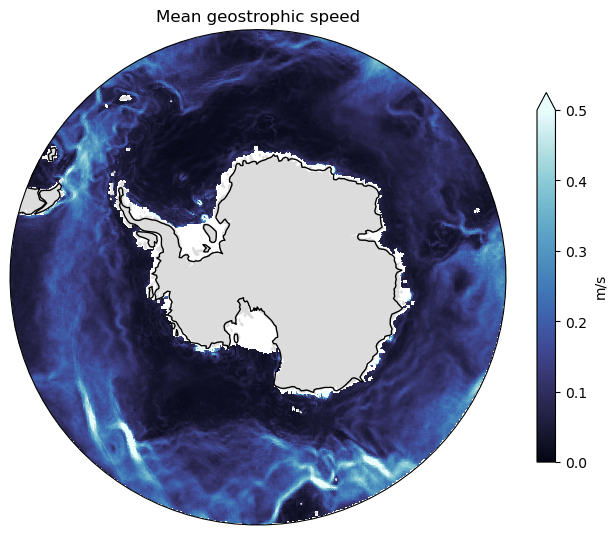

In [11]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())
ax = stereographic_axis(ax)
speed.mean('time').plot(ax = ax, transform = ccrs.PlateCarree(),
                        vmin = 0, vmax = .5, cmap = cm.cm.ice,
                        cbar_kwargs = {'label': 'm/s', 'shrink':.6})
plt.title('Mean geostrophic speed');

In this figure, it is very easy to see the higher surface speeds associated to the Antarctic Circumpolar Current.

Let's do a bit of a different plot. Let's do colours of `adt`, with vectors (arrows) built from our `u` and `v`.

<h4 style="color: red;">Question 1</h4>

What do you expect this plot to be like? How are the vectors and the contours of `adt` going to be with respect to each other?

*Answer here*

To do this plot, let's first calculate the time mean of `u` and `v`, cut them to have the same shape using `.sel()`. We need to do this, because when we apply the `.diff()` function at the beginning we loose one point in the direction we are differentiating along (you can't differentiate the last point!). We also need to use `.values` at the end because our funtion to plot arrows wants numpy arrays, not xarray dataarrays.

In [12]:
u_mean = u.mean('time').isel(lon = slice(1, None))
v_mean = v.mean('time').isel(lat = slice(1, None))

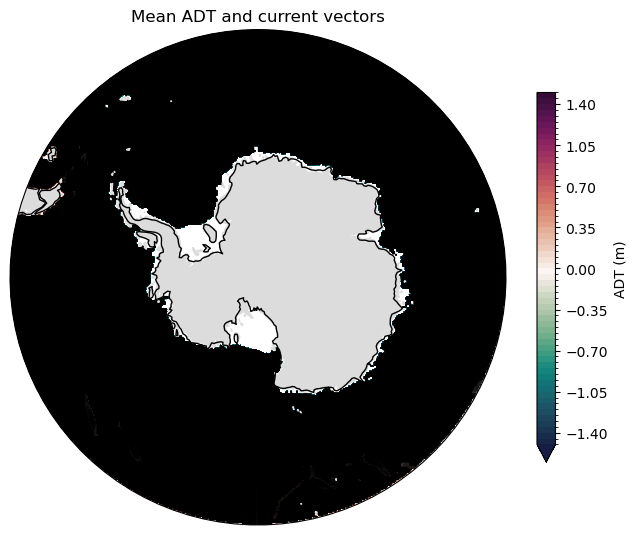

In [13]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())
ax = stereographic_axis(ax)
ds['adt'].mean('time').plot.contourf(ax = ax, transform = ccrs.PlateCarree(),
                                     levels = np.arange(-1.5, 1.55, .05), cmap = cm.cm.curl,
                                     cbar_kwargs = {'label': 'ADT (m)', 'shrink':.6})
plt.quiver(x = u_mean['lon'].values, y = u_mean['lat'].values, 
           u = u_mean.values, v = v_mean.values, transform = ccrs.PlateCarree())

plt.title('Mean ADT and current vectors');

This looks terrible! What has happened here is that there are too many vectors to plot, so many the end result is all black. Instead of doing this circumpolarly, let's do a smaller region plot at the Drake Passage:

In [14]:
u_mean_dp = u_mean.sel(lon = slice(-90, -40), lat = slice(-70, -50))
v_mean_dp = v_mean.sel(lon = slice(-90, -40), lat = slice(-70, -50))

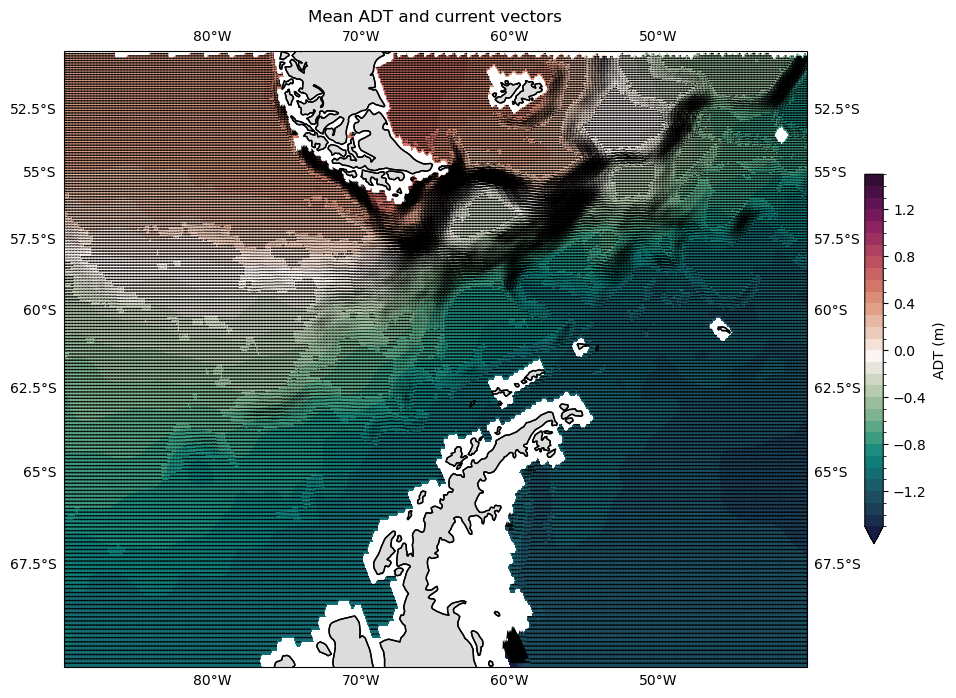

In [15]:
fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(projection = ccrs.Mercator(central_longitude = -65))
ax.set_extent([-90, -40, -70, -50], crs = ccrs.PlateCarree())
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gainsboro'))
ax.coastlines(resolution = "50m")
gl = ax.gridlines(draw_labels = True, linewidth = 0)
gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()

ds['adt'].mean('time').plot.contourf(ax = ax, transform = ccrs.PlateCarree(),
                                     levels = np.arange(-1.5, 1.6, .1), cmap = cm.cm.curl,
                                     cbar_kwargs = {'label': 'ADT (m)', 'shrink':.6})
plt.quiver(x = u_mean_dp['lon'].values, y = u_mean_dp['lat'].values, 
           u = u_mean_dp.values, v = v_mean_dp.values, transform = ccrs.PlateCarree())

plt.title('Mean ADT and current vectors');

Still too many vectors! A quick workaround is to plot skipping `n`. Let's try skipping 5:

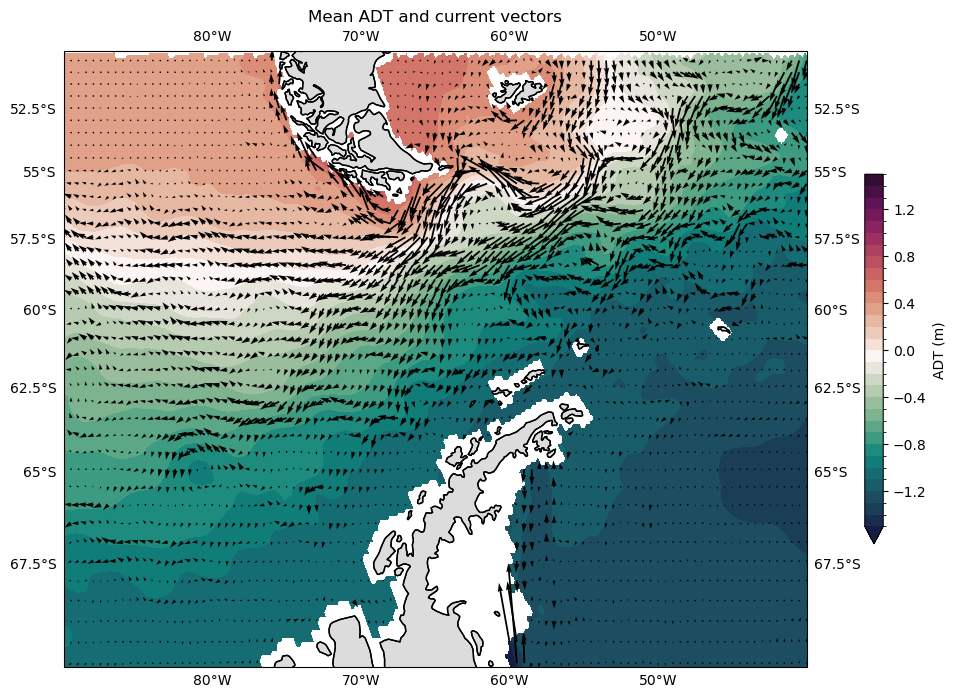

In [16]:
fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(projection = ccrs.Mercator(central_longitude = -65))
ax.set_extent([-90, -40, -70, -50], crs = ccrs.PlateCarree())
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gainsboro'))
ax.coastlines(resolution = "50m")
gl = ax.gridlines(draw_labels = True, linewidth = 0)
gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()

ds['adt'].mean('time').plot.contourf(ax = ax, transform = ccrs.PlateCarree(),
                                     levels = np.arange(-1.5, 1.6, .1), cmap = cm.cm.curl,
                                     cbar_kwargs = {'label': 'ADT (m)', 'shrink':.6})
plt.quiver(x = u_mean_dp['lon'].values[::5], y = u_mean_dp['lat'].values[::5], 
           u = u_mean_dp.values[::5,::5], v = v_mean_dp.values[::5,::5], transform = ccrs.PlateCarree())

plt.title('Mean ADT and current vectors');

<h4 style="color: red;">Question 2</h4>

How does the circulation here compare to your expectations after the discussion on Question 1? To help you answer this, you can plot an even smaller regions to better visualise contours and vectors. 

Spoiler: there is something not quite right. Once you've found it, fix it!

*Answer here*

<h4 style="color: red;">Question 3</h4>

Where do you see strongest currents? Looking at the sea surface height, can you explain why the currents are strongest there? 

*Answer here*